<a href="https://colab.research.google.com/github/lovenalee/Final-Project/blob/master/MajCrimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Basics").getOrCreate()

In [ ]:
df = spark.read.csv("MCI_2014_to_2019.csv", sep=",", header=True, inferSchema=True)

In [ ]:
df.show(truncate=False)

+-----------------+----------------+------+---------------+----------------------+----------------------+-----------+--------+-------+------------------------------+------------+-------------+-----------+-----------------+-----------------+------------+--------------+---------------+-------------+-------------------+-------------------+--------------+---------------+--------+-------+-------------------------------+----------+-------+--------+
|X                |Y               |Index_|event_unique_id|occurrencedate        |reporteddate          |premisetype|ucr_code|ucr_ext|offence                       |reportedyear|reportedmonth|reportedday|reporteddayofyear|reporteddayofweek|reportedhour|occurrenceyear|occurrencemonth|occurrenceday|occurrencedayofyear|occurrencedayofweek|occurrencehour|MCI            |Division|Hood_ID|Neighbourhood                  |Lat       |Long   |ObjectId|
+-----------------+----------------+------+---------------+----------------------+----------------------+-

In [ ]:
df.dtypes

[('X', 'double'),
 ('Y', 'double'),
 ('Index_', 'int'),
 ('event_unique_id', 'string'),
 ('occurrencedate', 'string'),
 ('reporteddate', 'string'),
 ('premisetype', 'string'),
 ('ucr_code', 'int'),
 ('ucr_ext', 'int'),
 ('offence', 'string'),
 ('reportedyear', 'int'),
 ('reportedmonth', 'string'),
 ('reportedday', 'int'),
 ('reporteddayofyear', 'int'),
 ('reporteddayofweek', 'string'),
 ('reportedhour', 'int'),
 ('occurrenceyear', 'int'),
 ('occurrencemonth', 'string'),
 ('occurrenceday', 'int'),
 ('occurrencedayofyear', 'int'),
 ('occurrencedayofweek', 'string'),
 ('occurrencehour', 'int'),
 ('MCI', 'string'),
 ('Division', 'string'),
 ('Hood_ID', 'int'),
 ('Neighbourhood', 'string'),
 ('Lat', 'double'),
 ('Long', 'double'),
 ('ObjectId', 'int')]

In [ ]:
from pyspark.sql import functions as func
from pyspark.sql.functions import *
df.select("reporteddate").dtypes
df1 = df.withColumn('date_only', split(df['reporteddate'], ' ').getItem(0))
df1.show(truncate=False)

+-----------------+----------------+------+---------------+----------------------+----------------------+-----------+--------+-------+------------------------------+------------+-------------+-----------+-----------------+-----------------+------------+--------------+---------------+-------------+-------------------+-------------------+--------------+---------------+--------+-------+-------------------------------+----------+-------+--------+----------+
|X                |Y               |Index_|event_unique_id|occurrencedate        |reporteddate          |premisetype|ucr_code|ucr_ext|offence                       |reportedyear|reportedmonth|reportedday|reporteddayofyear|reporteddayofweek|reportedhour|occurrenceyear|occurrencemonth|occurrenceday|occurrencedayofyear|occurrencedayofweek|occurrencehour|MCI            |Division|Hood_ID|Neighbourhood                  |Lat       |Long   |ObjectId|date_only |
+-----------------+----------------+------+---------------+----------------------+--

In [ ]:
grouped_df = df1.groupBy("date_only").count()
grouped_df.sort(func.col("date_only")).show(truncate=False)

+----------+-----+
|date_only |count|
+----------+-----+
|2014/01/01|100  |
|2014/01/02|65   |
|2014/01/03|53   |
|2014/01/04|64   |
|2014/01/05|74   |
|2014/01/06|68   |
|2014/01/07|92   |
|2014/01/08|86   |
|2014/01/09|82   |
|2014/01/10|64   |
|2014/01/11|62   |
|2014/01/12|92   |
|2014/01/13|80   |
|2014/01/14|82   |
|2014/01/15|68   |
|2014/01/16|74   |
|2014/01/17|94   |
|2014/01/18|94   |
|2014/01/19|70   |
|2014/01/20|80   |
+----------+-----+
only showing top 20 rows



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = grouped_df.toPandas()
pandas_df.dtypes
pandas_df = pandas_df.rename(columns={"date_only": "ds", "count": "y"})
pandas_df = pandas_df.sort_values(by=['ds'])
pandas_df['ds'] = pandas_df['ds'].str.replace('/','-')
pandas_df = pandas_df.reset_index(drop=True)
pandas_df.head()

,ds,y
0,2014-01-01,100
1,2014-01-02,65
2,2014-01-03,53
3,2014-01-04,64
4,2014-01-05,74


In [ ]:
pandas_df.dtypes
pandas_df = pandas_df['ds'] = pd.to_datetime(pandas_df['ds'], format='%y%m%d')

ValueError: ignored

In [ ]:
from fbprophet import Prophet

model = Prophet()
model.fit(pandas_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_df = model.make_future_dataframe(periods=730)

In [ ]:
predictions = model.predict(future_df)
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].head(366)


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2014-01-01,74.042817,58.756021,91.465258,85.782903,85.782903,85.782903
1,2014-01-02,73.609668,57.271330,89.735913,85.787710,85.787710,85.787710
2,2014-01-03,77.301042,61.807303,93.681799,85.792516,85.792516,85.792516
3,2014-01-04,73.050849,57.774986,89.476848,85.797322,85.797322,85.797322
4,2014-01-05,73.673626,57.890539,89.314321,85.802129,85.802129,85.802129
...,...,...,...,...,...,...,...
361,2014-12-28,72.960284,57.433191,88.446396,87.518001,87.518001,87.518001
362,2014-12-29,78.951606,63.457059,95.552723,87.522807,87.522807,87.522807
363,2014-12-30,75.833269,59.995661,90.720412,87.527613,87.527613,87.527613
364,2014-12-31,75.430110,59.875944,90.589628,87.532420,87.532420,87.532420


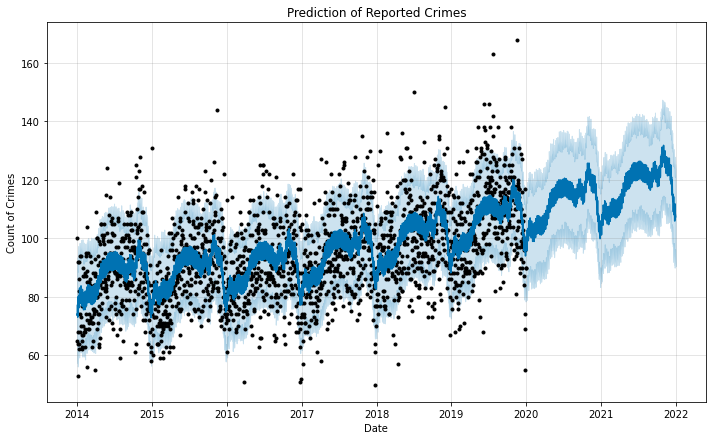

In [ ]:
fig1 = model.plot(predictions)
plt.title("Prediction of Reported Crimes")
plt.xlabel("Date")
plt.ylabel("Count of Crimes")
plt.show()

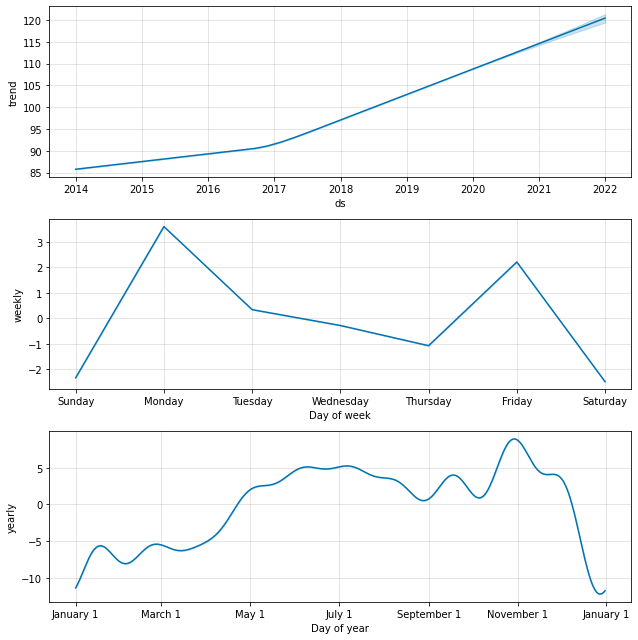

In [ ]:
fig2 = model.plot_components(predictions)

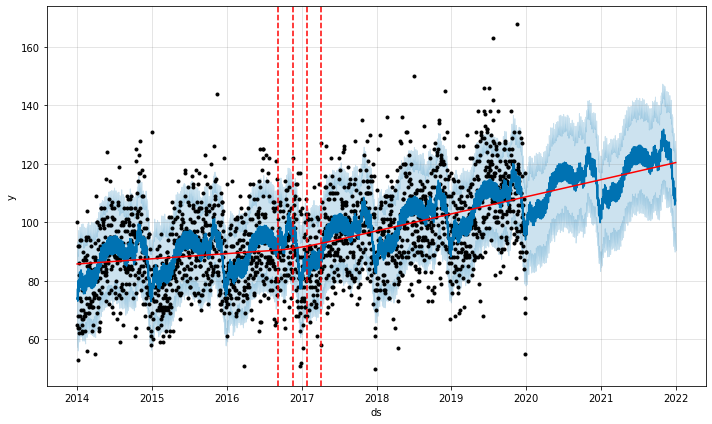

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig3 = model.plot(predictions) 
a = add_changepoints_to_plot(fig3.gca(), model, predictions)

<Figure size 1440x360 with 0 Axes>

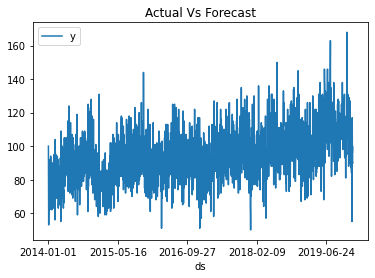

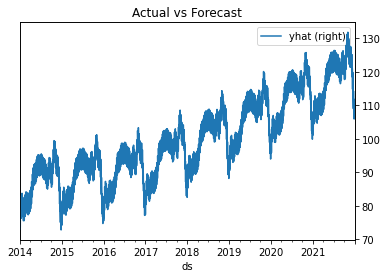

In [ ]:
plt.figure(figsize=(20,5))
# plotting the actual and forecast values

# ax = (pandas_df.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
pandas_df.plot(x='ds',y='y', title='Actual Vs Forecast')

# predictions.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast')
predictions.plot(x='ds',y='yhat', title='Actual vs Forecast', secondary_y=True)


<Figure size 864x360 with 0 Axes>

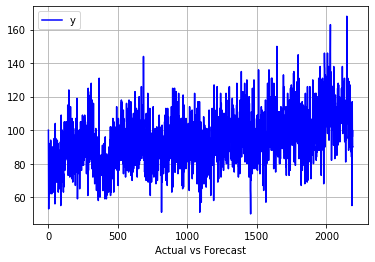

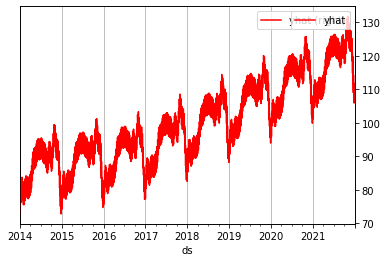

In [ ]:
plt.figure(figsize=(12,5))

# Number of request every 10 minutes
# log_10minutely_count_Series = log_df['IP'].resample('10min').count()
pandas_df.name="Actual"
pandas_df.plot(color='blue', grid=True)
plt.legend(loc='upper left')
plt.xlabel('Actual vs Forecast')

# Sum of response size over each 10 minute
# log_10minutely_sum_Series = log_df['Bytes'].resample('10min').sum()
predictions.name = 'Forecast'
predictions.plot(x='ds',y='yhat', color='red',grid=True, secondary_y=True)
plt.legend(loc='upper right')
plt.show()